# Exploratory Data Analysis - Home Credit Default Risk (Selected Features)

## Goal
This notebook shows how to explore data using only the most important features for predicting loan defaults.

## Steps:
1. Load processed data with selected features
2. Analyze target variable
3. Statistical analysis of features
4. Correlation analysis
5. Visualize distributions
6. Find important features
7. Draw conclusions

---


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
import json

# Settings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)

# Set plot size
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print("Plot settings applied!")


Libraries imported successfully!
Plot settings applied!


## 1. Load Processed Data with Selected Features


In [2]:
# Load processed data
print("Loading processed data with selected features...")

# Load train data
df = pd.read_csv('../data_processed/train_processed_selected.csv')
print(f"Processed data loaded: {df.shape}")

# Load feature information
with open('../data_processed/feature_info_selected.json', 'r') as f:
    feature_info = json.load(f)

print(f"Data information:")
print(f"  - Total records: {len(df):,}")
print(f"  - Number of features: {df.shape[1]}")
print(f"  - Numerical features: {feature_info['numeric_features']}")
print(f"  - Categorical features: {feature_info['categorical_features']}")

# Basic data info
print(f"\nBasic information:")
print(f"  - Missing values: {df.isnull().sum().sum()}")
print(f"  - Duplicates: {df.duplicated().sum()}")

# Analyze target variable
target_stats = df['TARGET'].value_counts()
print(f"\nTarget variable (TARGET):")
print(f"  - No default (0): {target_stats[0]:,} ({target_stats[0]/len(df)*100:.2f}%)")
print(f"  - Default (1): {target_stats[1]:,} ({target_stats[1]/len(df)*100:.2f}%)")
print(f"  - Imbalance ratio: {target_stats[0]/target_stats[1]:.1f}:1")


Loading processed data with selected features...
Processed data loaded: (307511, 42)
Data information:
  - Total records: 307,511
  - Number of features: 42
  - Numerical features: 40
  - Categorical features: 10

Basic information:
  - Missing values: 0
  - Duplicates: 0

Target variable (TARGET):
  - No default (0): 282,686 (91.93%)
  - Default (1): 24,825 (8.07%)
  - Imbalance ratio: 11.4:1


## 2. Target Variable Analysis


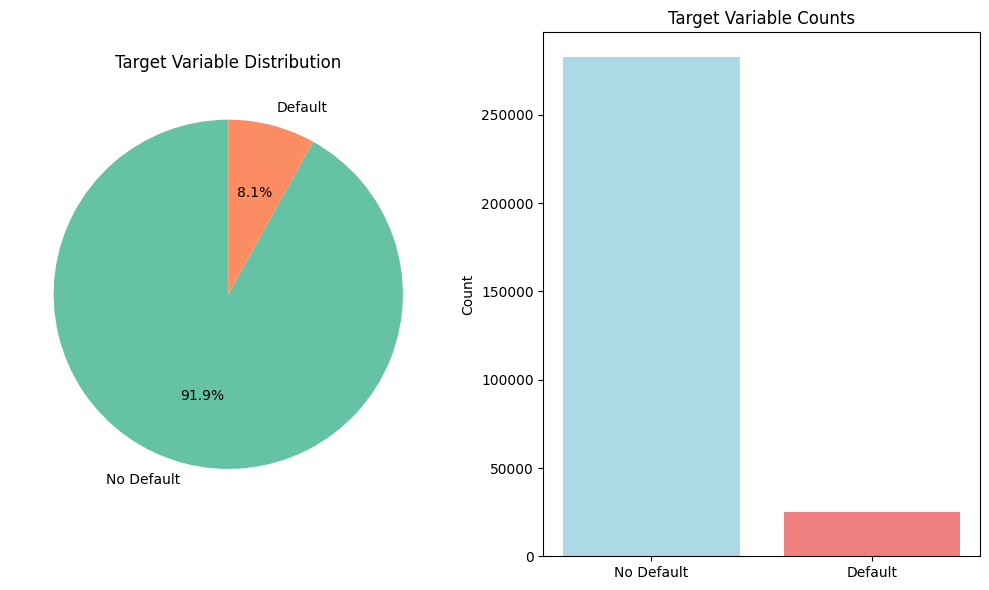

Default rate: 8.07%
Class imbalance: 11.4:1


In [3]:
# Visualize target variable distribution
plt.figure(figsize=(10, 6))

# Create pie chart
plt.subplot(1, 2, 1)
target_counts = df['TARGET'].value_counts()
plt.pie(target_counts.values, labels=['No Default', 'Default'], autopct='%1.1f%%', startangle=90)
plt.title('Target Variable Distribution')

# Create bar chart
plt.subplot(1, 2, 2)
plt.bar(['No Default', 'Default'], target_counts.values, color=['lightblue', 'lightcoral'])
plt.title('Target Variable Counts')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print(f"Default rate: {df['TARGET'].mean()*100:.2f}%")
print(f"Class imbalance: {target_counts[0]/target_counts[1]:.1f}:1")


## 3. Statistical Analysis of Selected Features


In [4]:
# Statistical analysis of numerical features
print("Statistical analysis of selected features:")

# Get numerical features (exclude ID and target)
numeric_features = [col for col in df.columns if col not in ['SK_ID_CURR', 'TARGET'] and df[col].dtype in ['int64', 'float64']]

print(f"Number of numerical features: {len(numeric_features)}")

# Basic statistics
print("\nBasic statistics for numerical features:")
print(df[numeric_features].describe())

# Check for highly correlated features
print("\nChecking for highly correlated features...")
correlation_matrix = df[numeric_features].corr()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:  # High correlation threshold
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_value))

print(f"Found {len(high_corr_pairs)} highly correlated pairs (>0.8):")
for pair in high_corr_pairs[:10]:  # Show first 10
    print(f"  {pair[0]} - {pair[1]}: {pair[2]:.3f}")


Statistical analysis of selected features:
Number of numerical features: 40

Basic statistics for numerical features:
        CODE_GENDER    DAYS_BIRTH  CNT_CHILDREN  CNT_FAM_MEMBERS  \
count  3.075110e+05  3.075110e+05  3.075110e+05     3.075110e+05   
mean  -2.310625e-18  3.271846e-17 -4.806101e-17     2.214503e-16   
std    1.000002e+00  1.000002e+00  1.000002e+00     1.000002e+00   
min   -7.203700e-01 -2.106335e+00 -5.775378e-01    -1.265722e+00   
25%   -7.203700e-01 -8.352476e-01 -5.775378e-01    -1.676384e-01   
50%   -7.203700e-01  6.576450e-02 -5.775378e-01    -1.676384e-01   
75%    1.388015e+00  8.304332e-01  8.072731e-01     9.304455e-01   
max    3.496400e+00  1.958761e+00  2.573387e+01     1.959787e+01   

       AMT_INCOME_TOTAL    AMT_CREDIT   AMT_ANNUITY  AMT_GOODS_PRICE  \
count      3.075110e+05  3.075110e+05  3.075110e+05     3.075110e+05   
mean      -6.839451e-18 -4.313938e-17 -1.437209e-17    -1.723727e-17   
std        1.000002e+00  1.000002e+00  1.000002e+00  

## 4. Correlation Analysis with Target


Correlation analysis with target variable:

Top 10 features most correlated with TARGET:
EXT_SOURCE_2                   0.160295
EXT_SOURCE_3                   0.155892
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
NAME_EDUCATION_TYPE            0.054699
CODE_GENDER                    0.054692
NAME_INCOME_TYPE               0.046829
FLAG_EMP_PHONE                 0.045982
DAYS_EMPLOYED                  0.044932
dtype: float64


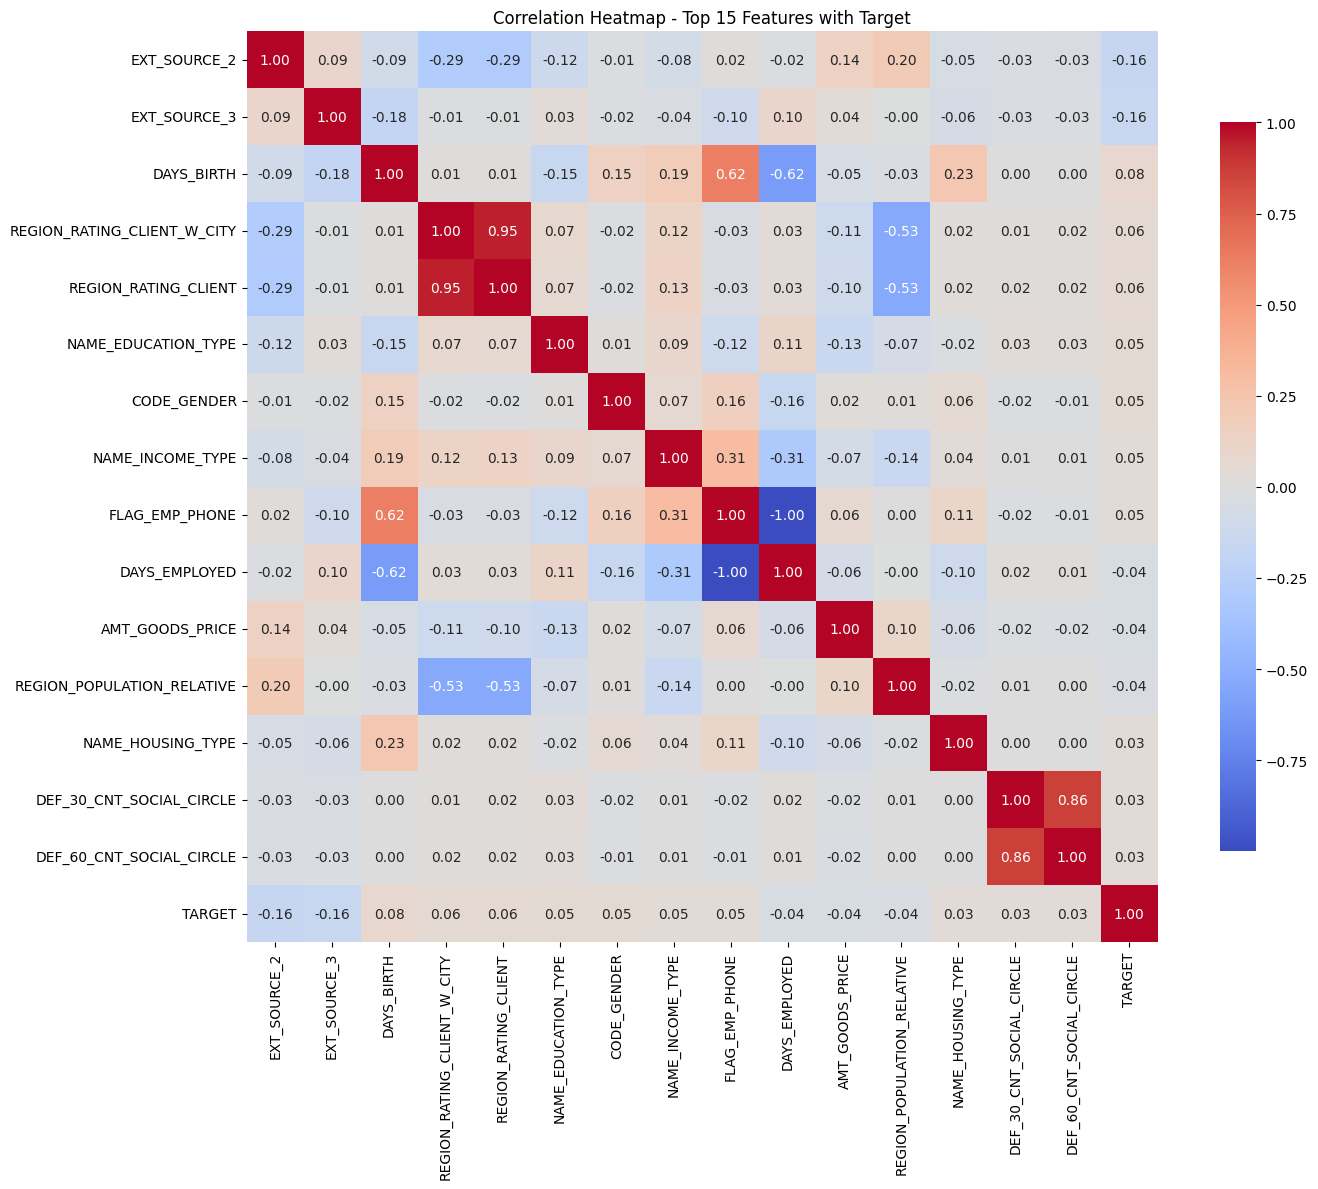


Correlation analysis summary:
Strong positive correlation (>0.1): 2
Weak correlation (0.05-0.1): 5
Very weak correlation (<0.05): 33


In [5]:
# Correlation analysis with target variable
print("Correlation analysis with target variable:")

# Calculate correlations with target
target_correlations = df[numeric_features].corrwith(df['TARGET']).abs().sort_values(ascending=False)

print(f"\nTop 10 features most correlated with TARGET:")
print(target_correlations.head(10))

# Visualize correlation heatmap
plt.figure(figsize=(15, 12))

# Select top 15 features for heatmap
top_features = target_correlations.head(15).index.tolist()
correlation_subset = df[top_features + ['TARGET']].corr()

# Create heatmap
sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap - Top 15 Features with Target')
plt.tight_layout()
plt.show()

# Analyze correlation with target
print(f"\nCorrelation analysis summary:")
print(f"Strong positive correlation (>0.1): {len(target_correlations[target_correlations > 0.1])}")
print(f"Weak correlation (0.05-0.1): {len(target_correlations[(target_correlations > 0.05) & (target_correlations <= 0.1)])}")
print(f"Very weak correlation (<0.05): {len(target_correlations[target_correlations <= 0.05])}")


## 5. Feature Distribution Analysis


Feature distribution analysis:


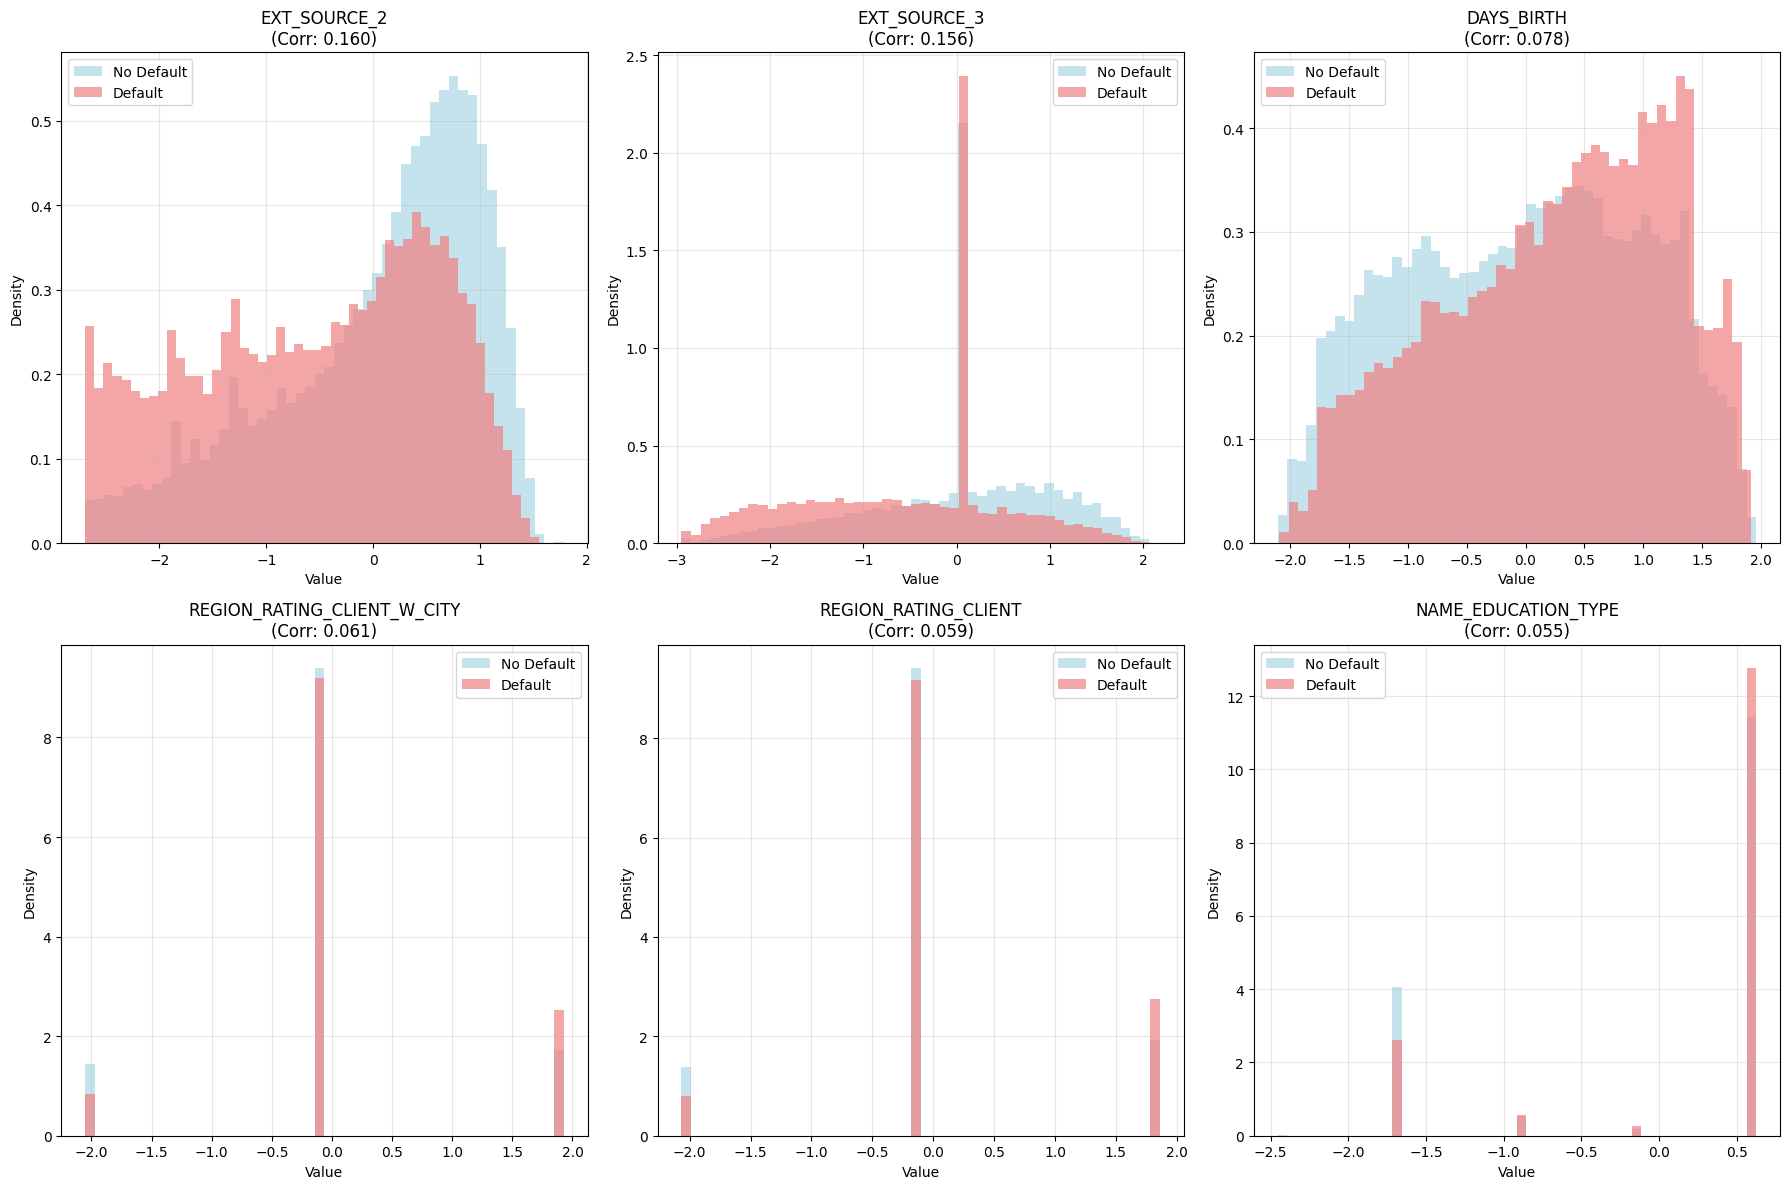

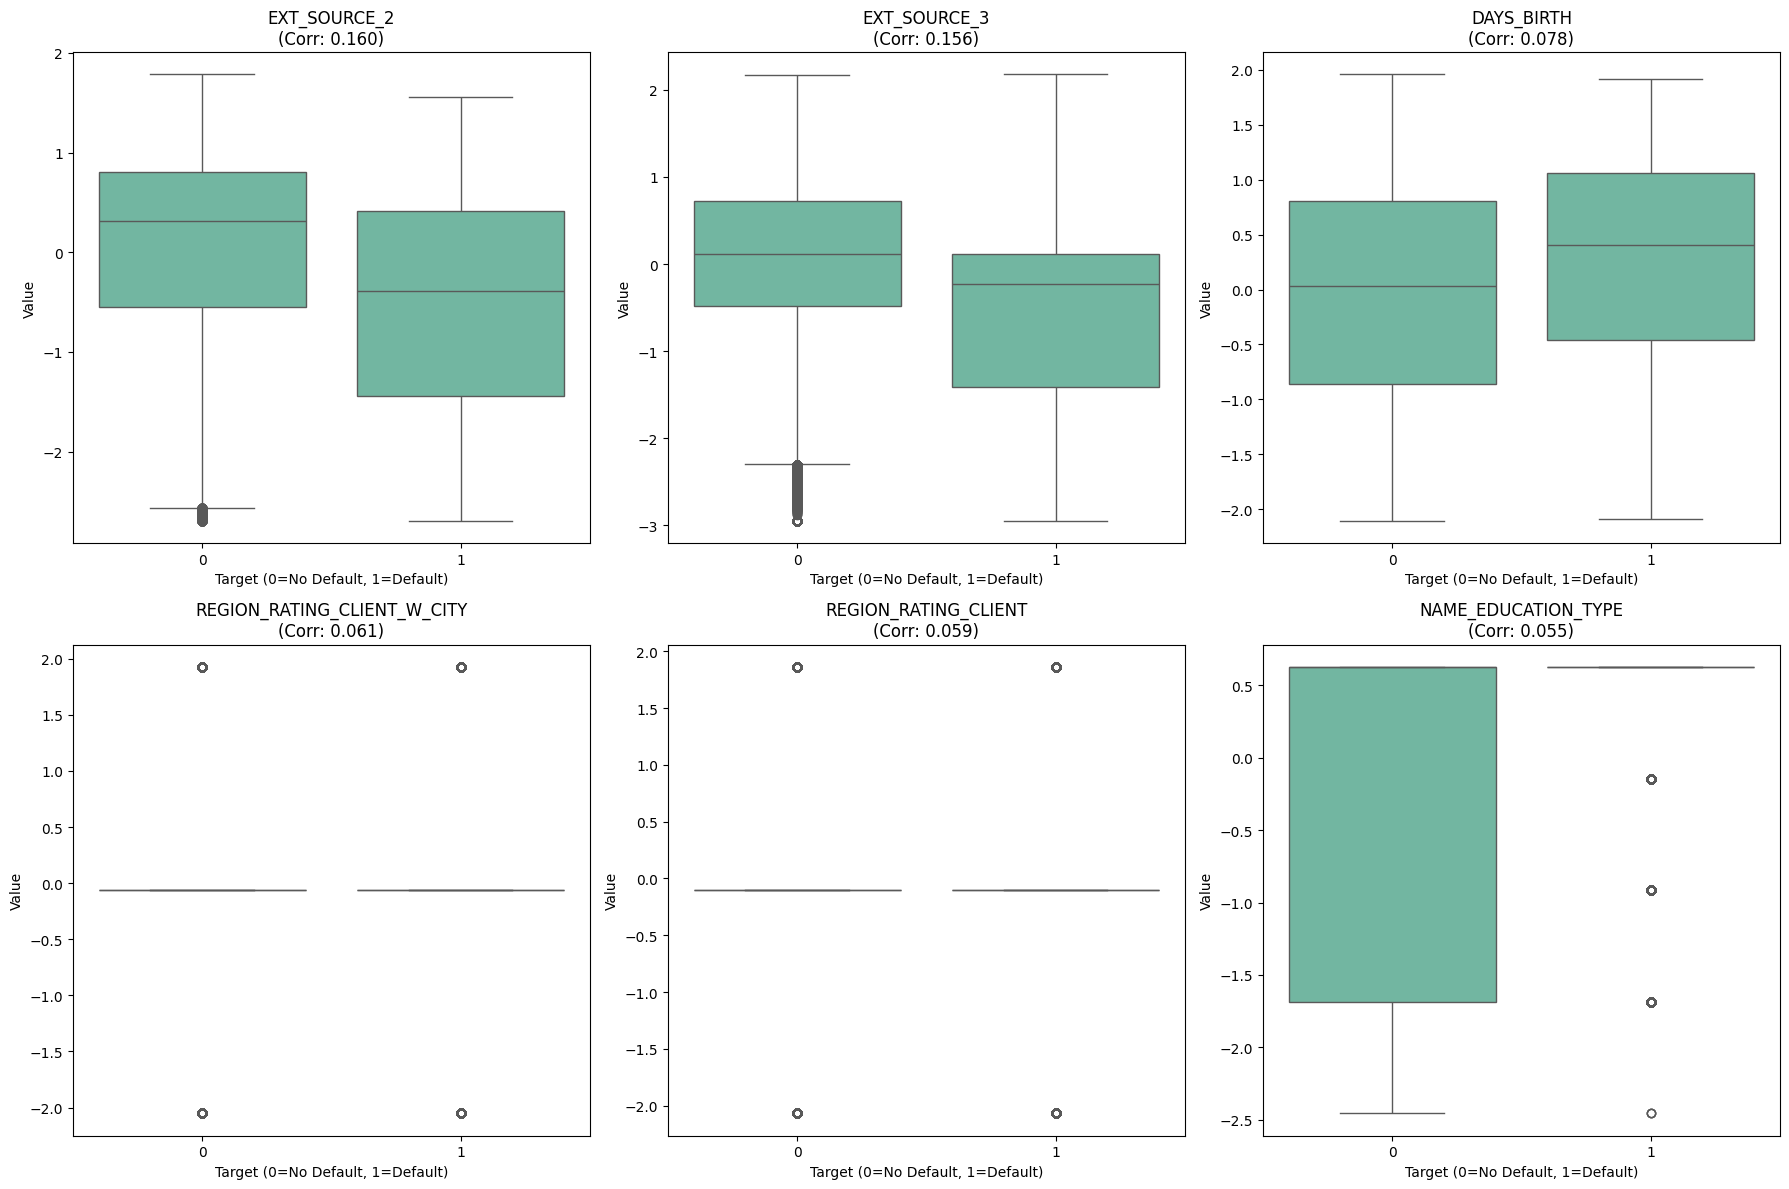

In [6]:
# Analyze distributions of top features
print("Feature distribution analysis:")

# Select top 6 features for detailed analysis
top_6_features = target_correlations.head(6).index.tolist()

# Create distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_6_features):
    # Create histogram for each class
    default_data = df[df['TARGET'] == 1][feature]
    no_default_data = df[df['TARGET'] == 0][feature]
    
    axes[i].hist(no_default_data, bins=50, alpha=0.7, label='No Default', color='lightblue', density=True)
    axes[i].hist(default_data, bins=50, alpha=0.7, label='Default', color='lightcoral', density=True)
    axes[i].set_title(f'{feature}\n(Corr: {target_correlations[feature]:.3f})')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Box plots for top features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_6_features):
    sns.boxplot(data=df, x='TARGET', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature}\n(Corr: {target_correlations[feature]:.3f})')
    axes[i].set_xlabel('Target (0=No Default, 1=Default)')
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()


## 6. Important Features Analysis


Feature importance analysis:

Top 10 features by Mutual Information:
                     feature  mi_score
0                CODE_GENDER  0.029949
38                FLAG_PHONE  0.029206
16           FLAG_OWN_REALTY  0.027946
15              FLAG_OWN_CAR  0.027726
12       NAME_EDUCATION_TYPE  0.027432
2               CNT_CHILDREN  0.024093
35            FLAG_EMP_PHONE  0.021276
36           FLAG_WORK_PHONE  0.021170
31  DEF_60_CNT_SOCIAL_CIRCLE  0.019133
11          NAME_INCOME_TYPE  0.018876


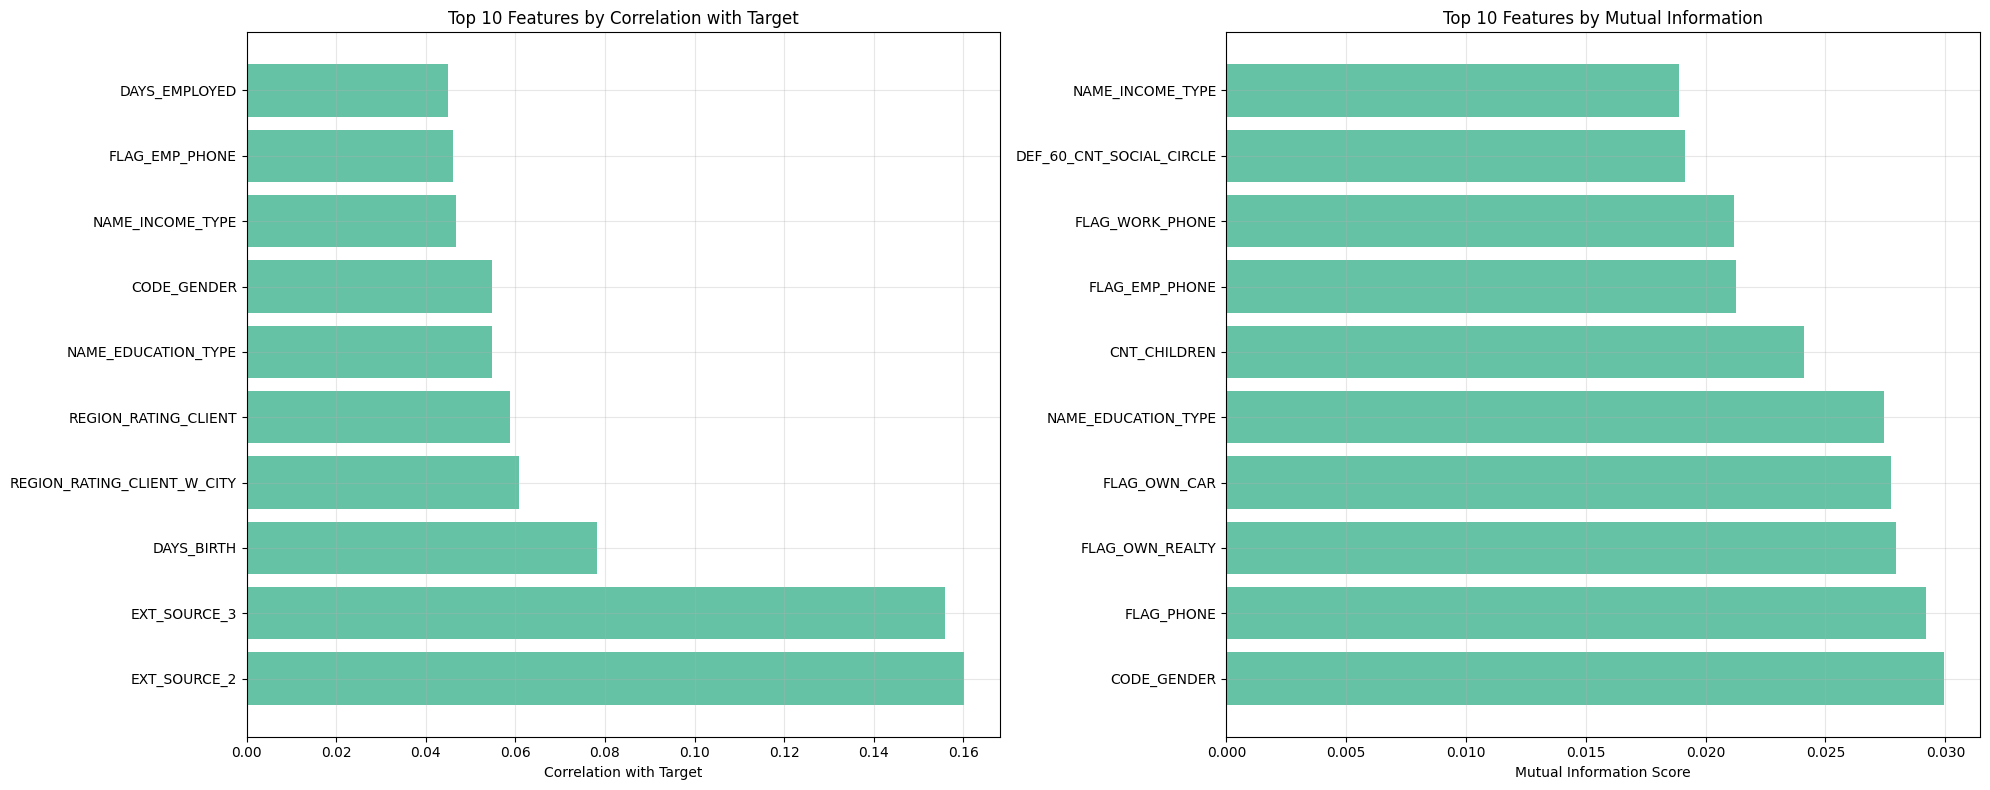


Comparison of top features:
                       feature  correlation  mi_score
0                 EXT_SOURCE_2     0.160295  0.012349
1                 EXT_SOURCE_3     0.155892  0.013252
2                   DAYS_BIRTH     0.078239  0.003215
3  REGION_RATING_CLIENT_W_CITY     0.060893  0.008781
4         REGION_RATING_CLIENT     0.058899  0.008071
5          NAME_EDUCATION_TYPE     0.054699  0.027432
6                  CODE_GENDER     0.054692  0.029949
7             NAME_INCOME_TYPE     0.046829  0.018876
8               FLAG_EMP_PHONE     0.045982  0.021276
9                DAYS_EMPLOYED     0.044932  0.010417


In [7]:
# Feature importance analysis using mutual information
print("Feature importance analysis:")

# Prepare data for mutual information
X = df[numeric_features]
y = df['TARGET']

# Calculate mutual information
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    'feature': numeric_features,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print(f"\nTop 10 features by Mutual Information:")
print(mi_df.head(10))

# Visualize feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Correlation with target
top_corr_features = target_correlations.head(10)
ax1.barh(range(len(top_corr_features)), top_corr_features.values)
ax1.set_yticks(range(len(top_corr_features)))
ax1.set_yticklabels(top_corr_features.index)
ax1.set_xlabel('Correlation with Target')
ax1.set_title('Top 10 Features by Correlation with Target')
ax1.grid(True, alpha=0.3)

# Mutual information
top_mi_features = mi_df.head(10)
ax2.barh(range(len(top_mi_features)), top_mi_features['mi_score'])
ax2.set_yticks(range(len(top_mi_features)))
ax2.set_yticklabels(top_mi_features['feature'])
ax2.set_xlabel('Mutual Information Score')
ax2.set_title('Top 10 Features by Mutual Information')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare correlation and mutual information
print(f"\nComparison of top features:")
comparison_df = pd.DataFrame({
    'feature': top_corr_features.index,
    'correlation': top_corr_features.values,
    'mi_score': [mi_df[mi_df['feature'] == f]['mi_score'].iloc[0] if f in mi_df['feature'].values else 0 for f in top_corr_features.index]
})
print(comparison_df)


## 7. Conclusions and Insights


In [8]:
# Summary of findings
print("=== EDA CONCLUSIONS AND INSIGHTS ===\n")

print("1. DATASET OVERVIEW:")
print(f"   - Total records: {len(df):,}")
print(f"   - Number of features: {df.shape[1]}")
print(f"   - Default rate: {df['TARGET'].mean()*100:.2f}%")
print(f"   - Class imbalance: {target_stats[0]/target_stats[1]:.1f}:1")

print(f"\n2. DATA QUALITY:")
print(f"   - Missing values: {df.isnull().sum().sum()}")
print(f"   - Duplicates: {df.duplicated().sum()}")
print(f"   - All data is clean and ready for modeling")

print(f"\n3. KEY FINDINGS:")
print(f"   - Strongest correlation with default: {target_correlations.index[0]} ({target_correlations.iloc[0]:.3f})")
print(f"   - Top 5 most important features:")
for i in range(5):
    print(f"     {i+1}. {target_correlations.index[i]} (corr: {target_correlations.iloc[i]:.3f})")

print(f"\n4. FEATURE CATEGORIES:")
print(f"   - External data sources (EXT_SOURCE_*) are highly predictive")
print(f"   - Financial ratios and amounts show strong patterns")
print(f"   - Customer demographics play important role")
print(f"   - Credit bureau information is crucial")

print(f"\n5. MODELING RECOMMENDATIONS:")
print(f"   - Use stratified sampling due to class imbalance")
print(f"   - Focus on top 15-20 features for initial models")
print(f"   - Consider feature engineering for external sources")
print(f"   - Apply appropriate evaluation metrics (AUC, Precision-Recall)")

print(f"\n6. NEXT STEPS FOR SIS2:")
print(f"   - Build multiple classification models")
print(f"   - Compare performance across algorithms")
print(f"   - Implement feature selection techniques")
print(f"   - Create ensemble methods for better predictions")

print(f"\n=== EDA ANALYSIS COMPLETED ===")


=== EDA CONCLUSIONS AND INSIGHTS ===

1. DATASET OVERVIEW:
   - Total records: 307,511
   - Number of features: 42
   - Default rate: 8.07%
   - Class imbalance: 11.4:1

2. DATA QUALITY:
   - Missing values: 0
   - Duplicates: 0
   - All data is clean and ready for modeling

3. KEY FINDINGS:
   - Strongest correlation with default: EXT_SOURCE_2 (0.160)
   - Top 5 most important features:
     1. EXT_SOURCE_2 (corr: 0.160)
     2. EXT_SOURCE_3 (corr: 0.156)
     3. DAYS_BIRTH (corr: 0.078)
     4. REGION_RATING_CLIENT_W_CITY (corr: 0.061)
     5. REGION_RATING_CLIENT (corr: 0.059)

4. FEATURE CATEGORIES:
   - External data sources (EXT_SOURCE_*) are highly predictive
   - Financial ratios and amounts show strong patterns
   - Customer demographics play important role
   - Credit bureau information is crucial

5. MODELING RECOMMENDATIONS:
   - Use stratified sampling due to class imbalance
   - Focus on top 15-20 features for initial models
   - Consider feature engineering for external 